In [6]:
%load_ext autoreload
%autoreload 2

In [1]:
# today can reproduce GPT-2 in about an hour
# GPT-2 paper is pretty light on details, so we reference the GPT-3 paper as well (not huge change in architecture)

* GPT-2 - [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
* GPT-3 - [Language Models are Few-Shot Learners](https://arxiv.org/pdf/2005.14165)

In [2]:
# - original written in tensorflow
# - karpathy not a fan
# - We use the huggingface transformers code instead of https://github.com/openai/gpt-2.git
#
# - actual source is here: https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
import transformers

In [ ]:
import torch
import tiktoken

In [13]:
import tabulate

In [6]:
# The GPT2 Model transformer with a language modeling head on top (linear layer with weights tied to the input embeddings).
# 
# note: the "language modeling" head is essentially unembedding it
#
# note: this is the 124M model (small), not the GPT-2 (XL) 1.5B model 
model_hf: transformers.GPT2LMHeadModel = transformers.GPT2LMHeadModel.from_pretrained('gpt2')

In [18]:
# show the raw tensors
#
# TODO(bschoen): Karpathy tends to use jupyter notebook on right of source, probably bigger monitor since GPU
#
sd_hf = model_hf.state_dict()

# print(tabulate.tabulate([(k, v.shape) for k, v in sd_hf.items()], headers=['key', 'shape']))

We can look at the raw tensors to interpret the shapes involved:

```python
# we derived this directly from the shapes
MLP_DIMENSIONALITY_FACTOR = 4

vocab_size = 50257
context_size = 1024
d_embed = d_embed

d_model_mlp = MLP_DIMENSIONALITY_FACTOR * d_embed

assert d_model_mlp == 3072

query_size = d_embed
key_size   = d_embed
value_size = d_embed

d_attn = query_size + key_size + value_size

assert d_attn == 2304

# so we get:

# key                                shape
# ---------------------------------  ------------------------
# token embeddings
transformer.wte.weight               torch.Size([vocab_size, d_embed])
# positional embeddings
transformer.wpe.weight               torch.Size([context_size, d_embed])
# add together to size `d_embed`
#
transformer.h.0.ln_1.weight          torch.Size([d_embed])
transformer.h.0.ln_1.bias            torch.Size([d_embed])
transformer.h.0.attn.c_attn.weight   torch.Size([d_embed, d_attn])
transformer.h.0.attn.c_attn.bias     torch.Size([d_attn])
transformer.h.0.attn.c_proj.weight   torch.Size([d_embed, d_embed])
transformer.h.0.attn.c_proj.bias     torch.Size([d_embed])
transformer.h.0.ln_2.weight          torch.Size([d_embed])
transformer.h.0.ln_2.bias            torch.Size([d_embed])
transformer.h.0.mlp.c_fc.weight      torch.Size([d_embed, d_model_mlp])
transformer.h.0.mlp.c_fc.bias        torch.Size([d_model_mlp])
transformer.h.0.mlp.c_proj.weight    torch.Size([d_model_mlp, d_embed])
transformer.h.0.mlp.c_proj.bias      torch.Size([d_embed])
# note: layer norms at the inputs
transformer.h.1.ln_1.weight          torch.Size([d_embed])
transformer.h.1.ln_1.bias            torch.Size([d_embed])
transformer.h.1.attn.c_attn.weight   torch.Size([d_embed, d_attn])
transformer.h.1.attn.c_attn.bias     torch.Size([d_attn])
...
transformer.h.11.mlp.c_proj.weight   torch.Size([d_model_mlp, d_embed])
transformer.h.11.mlp.c_proj.bias     torch.Size([d_embed])
# making up for layer norms at the inputs
transformer.ln_f.weight              torch.Size([d_embed])
transformer.ln_f.bias                torch.Size([d_embed])
# map back to vocab
lm_head.weight                       torch.Size([vocab_size, d_embed])



# key                                shape
# ---------------------------------  ------------------------
transformer.wte.weight               torch.Size([50257, 768])
transformer.wpe.weight               torch.Size([1024, 768])
transformer.h.0.ln_1.weight          torch.Size([768])
transformer.h.0.ln_1.bias            torch.Size([768])
transformer.h.0.attn.c_attn.weight   torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias     torch.Size([2304])
transformer.h.0.attn.c_proj.weight   torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias     torch.Size([768])
transformer.h.0.ln_2.weight          torch.Size([768])
transformer.h.0.ln_2.bias            torch.Size([768])
transformer.h.0.mlp.c_fc.weight      torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias        torch.Size([3072])
transformer.h.0.mlp.c_proj.weight    torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias      torch.Size([768])
# note: layer norms at the inputs
transformer.h.1.ln_1.weight          torch.Size([768])
transformer.h.1.ln_1.bias            torch.Size([768])
transformer.h.1.attn.c_attn.weight   torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias     torch.Size([2304])
...
transformer.h.11.ln_1.weight         torch.Size([768])
transformer.h.11.ln_1.bias           torch.Size([768])
transformer.h.11.attn.c_attn.weight  torch.Size([768, 2304])
transformer.h.11.attn.c_attn.bias    torch.Size([2304])
transformer.h.11.attn.c_proj.weight  torch.Size([768, 768])
transformer.h.11.attn.c_proj.bias    torch.Size([768])
transformer.h.11.ln_2.weight         torch.Size([768])
transformer.h.11.ln_2.bias           torch.Size([768])
transformer.h.11.mlp.c_fc.weight     torch.Size([768, 3072])
transformer.h.11.mlp.c_fc.bias       torch.Size([3072])
transformer.h.11.mlp.c_proj.weight   torch.Size([3072, 768])
transformer.h.11.mlp.c_proj.bias     torch.Size([768])
# making up for layer norms at the inputs
transformer.ln_f.weight              torch.Size([768])
transformer.ln_f.bias                torch.Size([768])
# map back to vocab
lm_head.weight                       torch.Size([50257, 768])
```

In [19]:
# note: positional embeddings in GPT-2 are *learned*, not fixed sinusoidal like they are in the original attention paper

# example view of the positional embedding weights
sd_hf["transformer.wpe.weight"].view(-1)[:20]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

Text(0.5, 1.0, 'Positional Embedding Weights')

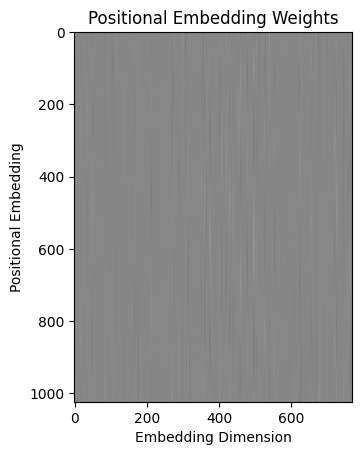

In [42]:
import matplotlib.pyplot as plt

# note: patterns across dimensions, but unintelligable (especially since also contains relative position)

# note: frequently used as a tool to inspect things
plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")
plt.xlabel("Embedding Dimension")
plt.ylabel("Positional Embedding")
plt.title("Positional Embedding Weights")
# plt.show()

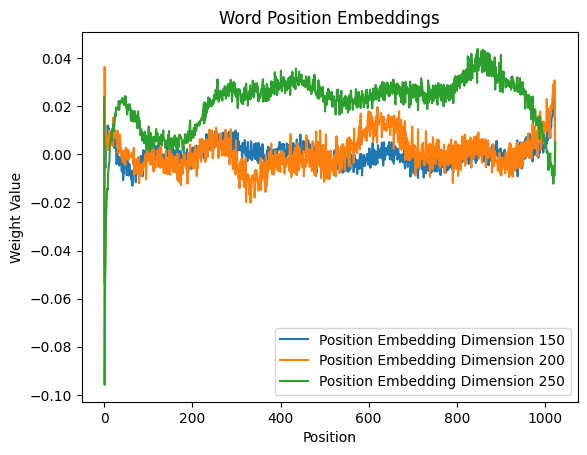

In [47]:
# look at a few individual column at random
#
# TODO(bschoen): Channel is a good term for dimension in the embedding space
#
# Can see some respond more or less depending on the position
#
# ex: green seems to focus on after 800
#
# Karpathy: "why knows"
# Karpathy: Can tell model not fully trained, because would expect this to be smoother
# Karpathy: In principle no reason these need to be smooth
plt.plot(sd_hf["transformer.wpe.weight"][:, 150], label='Position Embedding Dimension 150')
plt.plot(sd_hf["transformer.wpe.weight"][:, 200], label='Position Embedding Dimension 200')
plt.plot(sd_hf["transformer.wpe.weight"][:, 250], label='Position Embedding Dimension 250')

plt.xlabel('Position')
plt.ylabel('Weight Value')
plt.title('Word Position Embeddings')

plt.legend()

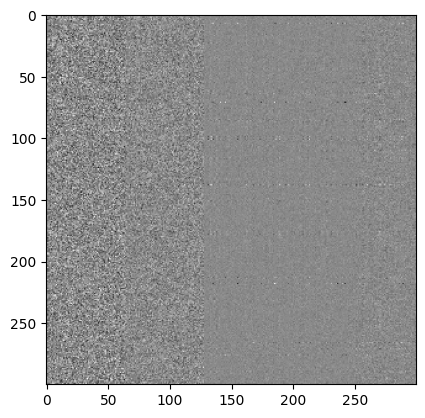

In [44]:
# we can do the same thing with any weights
#
# you see some structure, but again who knows
#
# {if you're into mechanistic interpretability}
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300,:300], cmap="gray")

In [48]:
# note: Karpathy took example from https://huggingface.co/openai-community/gpt2#how-to-use

# we can also sample from it using the weights
#
# note: we don't even use our initialized model?
#
generator = transformers.pipeline('text-generation', model='gpt2')

# set seed before generation
transformers.set_seed(42)

# note: different generations even if fixed seed
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

/Users/bronsonschoen/gpt_from_scratch/venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, I'm writing a new language for you. But first, I'd like to tell you about the language itself"},
 {'generated_text': "Hello, I'm a language model, and I'm trying to be as expressive as possible. In order to be expressive, it is necessary to know"},
 {'generated_text': "Hello, I'm a language model, so I don't get much of a license anymore, but I'm probably more familiar with other languages on that"},
 {'generated_text': "Hello, I'm a language model, a functional model... It's not me, it's me!\n\nI won't bore you with how"},
 {'generated_text': "Hello, I'm a language model, not an object model.\n\nIn a nutshell, I need to give language model a set of properties that"}]

In [ ]:
# want to write our own GPT-2 class so we can actually understand what's going on there, because it's just too complicated
# to use theirs as reference
# if want to create one from scratch

In [ ]:
# first we're going to create an instance and:
#  - allow loading from pretrained (to basically check against the existing model)
#  - figure out the layers we need, and also try to train it ourselves from scratch

In [16]:
# now we should be able to load the weights
from gpt_from_scratch.train_gpt2 import GPT

model = GPT.from_pretrained('gpt2')
print("yay! didn't crash")

loading weights from pretrained gpt: gpt2
yay! didn't crash


In [17]:
import torch
import torch.nn.functional as F

import tiktoken

In [18]:
# note: if doing with pipeline get the exact same thing,
#       so we're using the model weights correctly, just
#       some config in the sampling pipeline is different

# now we'll replicate the pipeline thing
num_return_sequences = 5
max_length = 30

# use MPS on mac
device = torch.device("mps")

# note: dropout is an example of something that's different in eval vs train
model.eval()
model.to(device)

# prefix tokens
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("Hello, I'm a language model,")
tokens = torch.tensor(tokens, dtype=torch.long) # (8,)

# 5 samples through
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) # (5, 8)

x = tokens.to(device)

# generate! right now x is (B, T) where B = 5, T = 8
# set the seed to 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)

while x.size(1) < max_length:

    # forward the model to get the logits
    with torch.no_grad():

        logits = model(x) # (B, T, vocab_size)

        # take the logits at the last position
        # throw away all the logits from things other than the last position
        logits = logits[:, -1, :] # (B, vocab_size)

        # get the probabilities
        probs = F.softmax(logits, dim=-1)

        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        #
        # "anything lower than the 50th, we clamp to 0 and never sample it"
        #
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)

        # select a token from the top-k probabilities
        # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1) # (B, 1)

        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)

        # append to the sequence
        x = torch.cat((x, xcol), dim=1)


In [20]:
# print the generated text
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

> Hello, I'm a language model, which means I'm familiar with it, but I'm not fluent in that. Well, with that said,
> Hello, I'm a language model, and the syntax, to make use of it, is pretty good. So why do you have that and not
> Hello, I'm a language model, I'm doing this work in Python, and then I'm writing code for Haskell.

So we can
> Hello, I'm a language model, and you're making assumptions about my use of them. I'm not a natural language learner. I'm
> Hello, I'm a language model, well, I'm from Java and have to write a programming language for it. I have my own vocabulary because
